In [78]:
import json
import os
import pickle
import random
import string
import subprocess
import sys
import time
from copy import copy
from datetime import datetime
from itertools import combinations, permutations

import networkx as nx
import numpy as np
from numpy.typing import ArrayLike, NDArray
from scipy.constants import N_A, elementary_charge, epsilon_0, k, pi

ListOfVals = ArrayLike
ListOfListsOfVals = ArrayLike


def born(energy: float) -> float:  # Assumes given in kJ/mol
    energy *= 1000  # Convert from kJ/mol to J/mol
    radius = (
        -(N_A / energy) * (elementary_charge**2 / (8 * pi * epsilon_0)) * (1 - 1 / 80)
    )  # in meters
    radius *= 1e10  # Change from meters to Angstrom
    return radius


def convert_energy_to_kJ_per_mol(val: float) -> float:  # Converts from kT to kJ/mol
    return N_A * val * k * 298 / 1000


def get_distance(
    position1: ListOfVals, position2: ListOfVals
) -> float:  # Gets the distance between two lists of three floats
    return np.sqrt(np.sum([(position1[i] - position2[i]) ** 2 for i in range(0, 3)]))


def convert_to_polar(position: ListOfVals, center: ListOfVals) -> ListOfVals:
    """
    Takes in a cartesian position and returns tuple (r, theta, phi).
    """
    rel_x, rel_y, rel_z = [position[i] - center[i] for i in range(3)]
    r = get_distance(position, center)
    theta = np.arccos(rel_z / r)
    phi = np.sign(rel_y) * np.arccos(rel_x / np.sqrt(rel_x**2 + rel_y**2))
    return (r, theta, phi)


def run_pb(
    positions, radii, charges, focus_atom_index=None, cpus=1, scale=10, indi=1, exdi=80
) -> dict:
    """
    Runs Poisson-Boltzmann on working_data/params.{id}.prm and outputs to working_data/output.log
    """

    # positions, radii, charges, self_energy_calc, focus_atom_index, cpus = input

    assert (
        len(positions) == len(radii) == len(charges)
    ), "Lengths of positions, radii, and charges must be identical!"

    # assert not (self_energy_calc ^ (focus_atom_index is not None)), (
    #     "self_energy_calc and focus_atom_index must be both unspecified or both"
    #     " specified!"
    # )

    rng = np.random.default_rng()
    id = "".join(random.choices(string.ascii_letters + string.digits, k=16))

    charge_strings = ["atom__resnumbc_charge_\n"]
    radius_strings = ["atom__res_radius_\n"]
    pdb_strings = []

    atom_names = list(
        permutations(list(string.ascii_uppercase), 2)
    )
    for i in range(0, len(positions)):
        atomname = "".join(atom_names[i])
        pos = positions[i]
        # if self_energy_calc and (i != focus_atom_index):
        #     charge = 0.0
        #     radius = 0.0
        # else:
        charge = charges[i]
        radius = radii[i]
        charge_strings.append(f"  {atomname.ljust(4)}          {charge:.4f}\n")
        radius_strings.append(f"{atomname.ljust(4)}       {float(radius):.4f}\n")
        pdb_strings.append(
            f"{'ATOM'.ljust(7)}{str(i+1).rjust(4)}  {atomname.ljust(3)}             "
            f" {str(round(pos[0],3)).rjust(8)}{str(round(pos[1],3)).rjust(8)}{str(round(pos[2],3)).rjust(8)} "
            f"                     {'Ar'.rjust(2)}\n"
        )

    if not os.path.exists("working_data"):
        os.makedirs("working_data")
    with open(f"working_data/custom.{id}.crg", "w") as f:
        f.writelines(charge_strings)
    with open(f"working_data/custom.{id}.siz", "w") as f:
        f.writelines(radius_strings)
    with open(f"working_data/custom.{id}.pdb", "w") as f:
        f.writelines(pdb_strings)

    lines = []
    with open("params.prm", "r") as f:
        for line in f.readlines():
            l = line.replace("%%SCALE%%", str(scale))
            l = l.replace("%%ID%%", id)
            if focus_atom_index is not None:
                cx, cy, cz = positions[focus_atom_index]
                center = f"{cx:0.4f},{cy:0.4f},{cz:0.4f}"
            else:
                center = "0.0,0.0,0.0"
            l = l.replace("%%CENTER%%", center)
            # if ("indi=" in line) and (not line[0] == "!"):
            #     indi = float(
            #         "".join([c if c.isnumeric() or c == "." else "" for c in line])
            #     )
            # if ("exdi=" in line) and (not line[0] == "!"):
            #     exdi = float(
            #         "".join([c if c.isnumeric() or c == "." else "" for c in line])
            #     )
            l = l.replace("%%INDI%%", str(indi))
            l = l.replace("%%EXDI%%", str(exdi))
            lines.append(l)
    with open(f"working_data/params.{id}.prm", "w") as f:
        f.writelines(lines)

    # os.system(f"mpirun -np {np} delphi params.prm.{id} > output.log.{id}")
    # subprocess.run([f"mpirun -np {cpus} delphi params.prm.{id} > output.log.{id}".split(" ")], stdout=subprocess.PIPE).stdout.decode('utf-8')
    try:
        output = subprocess.check_output(
            [
                (
                    (
                        f"mpirun -np {cpus} {os.environ['DELPHIEXEC']} working_data/params.{id}.prm >"
                        f" working_data/output.log"
                    )
                    if (cpus != 1)
                    else (
                        f"{os.environ['DELPHIEXEC']} working_data/params.{id}.prm >"
                        f" working_data/output.log"
                    )
                ),
                f"sleep 5s",
            ],
            shell=True,
            text=True,
        )
    except:
        print("ERROR RUNNING DELPHI!")
        return {"total_grid": rng.integers(0, 1000)}
    with open(f"working_data/output.log", "r") as f:
        energies = {}
        counter = 0
        for line in f.readlines()[::-1]:
            if "Energy> All required energy terms but grid energy" in line:
                energies["all_but_grid"] = float(line[:69][-10:])
                counter += 1
            if "Energy> Coulombic energy" in line:
                energies["coulombic"] = float(line[:69][-10:])
                counter += 1
            if "Energy> Corrected reaction field energy" in line:
                energies["corrected_RF"] = float(line[:69][-10:])
                counter += 1
            if "Energy> Total grid energy" in line:
                energies["total_grid"] = float(line[:69][-10:])
                counter += 1
            if counter >= 4:
                break

    energies["grid_pots_at_atoms"] = {}
    energies["coul_pots_at_atoms"] = {}
    with open(f"working_data/potentials.{id}.frc", "r") as f:
        should_read = False
        for line in f.readlines():
            if (
                "ATOM DESCRIPTOR         ATOM COORDINATES (X,Y,Z)    GRID PT. COUL. POT"
                in line
            ):
                should_read = True
                continue
            if should_read and (not "total energy =" in line):
                energies["grid_pots_at_atoms"][
                    atom_names.index(tuple(line[0:2]))
                ] = float(line[50:60])
                energies["coul_pots_at_atoms"][
                    atom_names.index(tuple(line[0:2]))
                ] = float(line[60:70])

    os.remove(f"working_data/params.{id}.prm")
    os.remove(f"working_data/custom.{id}.crg")
    os.remove(f"working_data/custom.{id}.siz")
    os.remove(f"working_data/custom.{id}.pdb")
    os.remove(f"working_data/output.log")
    os.remove(f"working_data/potentials.{id}.frc")
    # os.remove(f"working_data/phimap.{id}.cube")

    return energies


ListOfVals = list[float]
ListOfListsOfVals = list[list[float]]


class System:
    """
    A system of atoms.
    """

    def __init__(self, positions=None, radii=None, charges=None) -> None:
        self.positions, self.radii, self.charges = (None, None, None)

        if positions is not None:
            self.set_positions(positions)
        if radii is not None:
            self.set_radii(radii)
        if charges is not None:
            self.set_charges(charges)

        self.graph = None
        self.id = "".join(random.choices(string.ascii_letters + string.digits, k=16))

    def set_positions(self, positions: ListOfListsOfVals, overwrite=False) -> None:
        if self.positions is not None and not overwrite:
            raise ValueError(
                "self.positions is already set. To overwrite, specify overwrite=True"
            )
        else:
            self.positions = positions

    def set_radii(self, radii: ListOfVals, overwrite=False) -> None:
        if self.radii is not None and not overwrite:
            raise ValueError(
                "self.radii is already set. To overwrite, specify overwrite=True"
            )
        else:
            self.radii = radii

    def set_charges(self, charges: ListOfVals, overwrite=False) -> None:
        if self.charges is not None and not overwrite:
            raise ValueError(
                "self.charges is already set. To overwrite, specify overwrite=True"
            )
        else:
            self.charges = charges

    def check(self) -> None:
        checklist = [
            attribute is None
            for attribute in (self.positions, self.radii, self.charges)
        ]
        if True in checklist:
            empty_attribute = ("positions", "radii", "charges")[checklist.index(True)]
            raise ValueError(f"The attribute self.{empty_attribute} is None")

        checklist = [
            isinstance(attribute, (list, tuple, np.ndarray))
            for attribute in (self.positions, self.radii, self.charges)
        ]
        if False in checklist:
            mistyped_attribute = ("positions", "radii", "charges")[
                checklist.index(False)
            ]
            raise ValueError(
                f"The attribute self.{mistyped_attribute} is not of type list or tuple."
            )

        if not len(self.positions) == len(self.radii) == len(self.charges):
            raise ValueError(
                "The attributes self.positions, self.radii, and self.charges are not"
                " the same length"
                f" ({[len(self.positions), len(self.radii), len(self.charges)]})"
            )

    def get_scale(self) -> float:
        """
        Return the DelPhi `scale` parameter that should be used. Higher values make for
        more accurate but more time/memory hungry calculations. Scales cubically!
        """

        if self.radii is None:
            raise ValueError(
                "At least one radius must be defined to use self.get_scale()"
            )
        count = 0
        for radius in self.radii:
            if radius > 0:
                count += 1
        if count <= 3:
            return 30
        else:
            return 10

    def calculate_born_radius_with_pb(self, atom_index: int) -> float:
        """
        Finds the solvation free energy of the atom with index `atom_index` via PB, then uses the Born equation
        to determine what radius of an ion of the same charge would have to be to recreate the same solvation
        free energy in a system with no other atoms.
        """

        # Step 1: Get the energy of the ion in vacuum (with all other atoms neutral)

        # Step 2: Get the energy of the ion in water (with all other atoms neutral)

        # Step 3: Use the difference in energies (the solvation free energy) in the Born equation

        self.check()
        scale = self.get_scale()

        temp_charges = []
        for i, charge in enumerate(self.charges):
            if i == atom_index:
                temp_charges.append(charge)
            else:
                temp_charges.append(0)

        vacuum_energies = run_pb(
            positions=self.positions,
            radii=self.radii,
            charges=temp_charges,
            focus_atom_index=atom_index,
            cpus=1,
            scale=scale,
            indi=1,
            exdi=1,
        )
        vacuum_energy = convert_energy_to_kJ_per_mol(vacuum_energies["total_grid"])
        # print(f"vacuum_energy: {vacuum_energy} kJ/mol")

        solvated_energies = run_pb(
            positions=self.positions,
            radii=self.radii,
            charges=temp_charges,
            focus_atom_index=atom_index,
            cpus=1,
            scale=scale,
            indi=1,
            exdi=80,
        )
        solvated_energy = convert_energy_to_kJ_per_mol(solvated_energies["total_grid"])
        # print(f"solvated_energy: {solvated_energy} kJ/mol")

        solvation_free_energy = solvated_energy - vacuum_energy
        # print(f"solvation_free_energy: {solvation_free_energy} kJ/mol")

        return born(solvation_free_energy)

    def calculate_born_radius_with_pure_VDW_integral_old(
        self, atom_index: int, scale=None
    ) -> float:
        self.check()
        if not scale:
            scale = self.get_scale()

        # Calcualte the center of mass of the atoms in the system
        # center_of_mass = [
        #     sum([self.positions[j][i] for j in range(len(self.positions))])
        #     / len(self.positions)
        #     for i in range(3)
        # ]
        center = np.array(self.positions[atom_index])

        # Get the diameter of the sphere in which to integrate
        d = np.max(np.linalg.norm(np.array(self.positions) - center, axis=1)) + 1 * max(
            self.radii
        )

        # Create a cube of gridpoints that is larger than the sphere
        X = np.arange(center[0] - d, center[0] + d, 1 / scale)
        Y = np.arange(center[1] - d, center[1] + d, 1 / scale)
        Z = np.arange(center[2] - d, center[2] + d, 1 / scale)
        X, Y, Z = np.meshgrid(X, Y, Z)

        points_in_cube = np.stack((X.flatten(), Y.flatten(), Z.flatten()), axis=1)
        distances = np.linalg.norm(points_in_cube - center, axis=1)
        points_in_sphere = points_in_cube[
            (self.radii[atom_index] < distances) & (distances < d)
        ]

        # Keep a list of gridpoints that are inside the sphere in which to integrate
        # for point in points_in_sphere:
        #     in_solvent = True
        #     # Check if this point is inside an atom
        #     for i, position in enumerate(self.positions):
        #         if get_distance(point, position) < self.radii[i]:
        #             in_solvent = False
        #             break
        #     if in_solvent:
        #         r, theta, phi = convert_to_polar(point, center)
        #         integral += 1 / (4 * np.pi * (r**4))

        integral = np.sum(
            np.all(
                np.linalg.norm(
                    points_in_sphere[:, None, :] - np.array(self.positions), axis=2
                )
                > self.radii,
                axis=1,
            )
            / np.linalg.norm(points_in_sphere - center, axis=1) ** 4
        ) / (4 * np.pi)

        # Calculate the volume of the sphere
        volume = 4 / 3 * np.pi * d**3 - 4 / 3 * np.pi * self.radii[atom_index] ** 3

        # Calculate the integral by getting the average value and multiplying by the volume
        alpha = 1 / (integral * volume / len(points_in_sphere))
        return alpha

    def calculate_interatomic_potential(self, atom_index1: int, atom_index2: int):
        """
        Use PB calculations to get the potential on atom 1 due to atom 2's charge.
        The calculation is: potential at 1 due to 2 = potential at 1 with 2 unchanged - potential at 1 with 2 neutral.
        """
        self.check()
        scale = self.get_scale()

        # Get potential at 1 normally
        energies = run_pb(
            self.positions,
            self.radii,
            self.charges,
            focus_atom_index=atom_index1,
            scale=scale,
            indi=1,
            exdi=80,
        )
        first_term = convert_energy_to_kJ_per_mol(
            energies["grid_pots_at_atoms"][atom_index1]
        )

        # Get potential at 1 with 2 set to neutral
        temp_charges = [
            charge if i != atom_index2 else 0 for (i, charge) in enumerate(self.charges)
        ]
        energies = run_pb(
            self.positions,
            self.radii,
            temp_charges,
            focus_atom_index=atom_index1,
            scale=scale,
            indi=1,
            exdi=80,
        )
        second_term = convert_energy_to_kJ_per_mol(
            energies["grid_pots_at_atoms"][atom_index1]
        )

        return first_term - second_term

    # Fully rewritten for optimization by ChatGPT-4o 6/8/2024
    def calculate_born_radius_with_pure_VDW_integral(
        self, atom_index: int, scale=None, chunk_size=1000000
    ) -> float:
        """
        Take a cube containing all atoms. Then, for all gridpoints inside of the sphere circumscribed in the cube,
        use those grid points to calculate an integral dependent on whether a gridpoint is inside an atom or in solvent.
        """
        self.check()
        if not scale:
            scale = self.get_scale()

        center = np.array(self.positions[atom_index])

        # Get the diameter of the sphere in which to integrate
        d = np.max(np.linalg.norm(np.array(self.positions) - center, axis=1)) + 1 * max(
            self.radii
        )

        # Create ranges for gridpoints that are larger than the sphere
        X_range = np.arange(center[0] - d, center[0] + d, 1 / scale)
        Y_range = np.arange(center[1] - d, center[1] + d, 1 / scale)
        Z_range = np.arange(center[2] - d, center[2] + d, 1 / scale)

        def chunk_generator():
            chunk = []
            for x in X_range:
                for y in Y_range:
                    for z in Z_range:
                        point = np.array([x, y, z])
                        distance = np.linalg.norm(point - center)

                        # Check if the gridpoint is outside the focus atom but inside the sphere
                        if self.radii[atom_index] < distance < d:
                            chunk.append((point, distance))
                            if len(chunk) >= chunk_size:
                                yield chunk
                                chunk = []
            if chunk:
                yield chunk

        integral = 0.0
        num_points_in_sphere = 0
        for chunk in chunk_generator():
            points = np.array([item[0] for item in chunk])
            num_points_in_sphere += len(points)
            distances = np.array([item[1] for item in chunk])
            point_distances = np.linalg.norm(
                points[:, None, :] - np.array(self.positions), axis=2
            )
            valid_points = np.all(point_distances > self.radii, axis=1)
            integral += np.sum(1 / distances[valid_points] ** 4)

        integral /= 4 * np.pi

        # Calculate the volume of the sphere
        volume = 4 / 3 * np.pi * d**3 - 4 / 3 * np.pi * self.radii[atom_index] ** 3

        # Calculate the integral by getting the average value and multiplying by the volume
        alpha = 1 / (integral * volume / num_points_in_sphere)
        return alpha

    def create_networkx_graph(self, delete_existing=False):
        """
        Create a complete graph in networkx where nodes are atoms and edges
        are interatomic distances. Nodes can be given properties using
        methods like `self.assign_radii_to_graph()`.
        """
        assert (
            self.graph is None
        ) or delete_existing, "A graph already exists for this `System`. To rewrite it, use `delete_existing=True`."
        graph = nx.Graph()

        for i, position in enumerate(system.positions):
            graph.add_node(i)
        for a, b in combinations(range(0, len(system.positions)), r=2):
            dist = np.linalg.norm(
                np.array(system.positions[a]) - np.array(system.positions[b])
            )
            graph.add_edge(a, b, weight=dist)

        self.graph = graph
        return

    def assign_radii_to_graph(self):
        """
        Give each node in `self.graph` the property of its cavity radius.
        """
        assert (
            self.graph is not None
        ), "The `System` must have a graph before calling `self.assign_radii_to_graph()`."
        radii_dict = {}
        for i, node in enumerate(self.graph.nodes):
            radii_dict[i] = {"radius": self.radii[i]}
        nx.set_node_attributes(self.graph, radii_dict)
        return


def get_born_radius(system: System, atom_index: int) -> tuple:
    BR_pb = system.calculate_born_radius_with_pb(atom_index)
    BR_pure_VDW = system.calculate_born_radius_with_pure_VDW_integral(atom_index)
    return (BR_pb, BR_pure_VDW)

In [43]:
s = "AB                      0.0000    0.0000    0.000016716.2635    0.0000"

In [2]:
import matplotlib.pyplot as plt
import networkx as nx

In [89]:
system = System()
system.set_positions([[0, 0, 0], [0, 0, 5], [0, 0, 2.5]])
system.set_radii([0, 0, 10])
system.set_charges([1, 1, 0])

In [84]:
system.calculate_interatomic_potential(0, 1)

3.3595267994585356

In [90]:
system.calculate_interatomic_potential(0, 1)

ERROR RUNNING DELPHI!


KeyError: 'grid_pots_at_atoms'

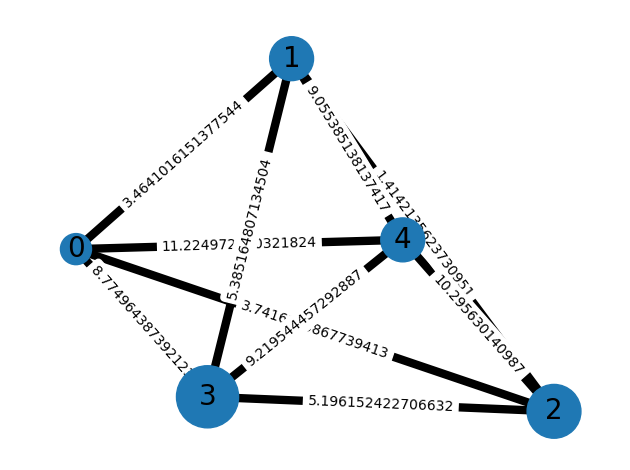

In [4]:
graph = nx.Graph()
for i, position in enumerate(system.positions):
    graph.add_node(i)
for a, b in combinations(range(0, len(system.positions)), r=2):
    dist = np.linalg.norm(np.array(system.positions[a]) - np.array(system.positions[b]))
    graph.add_edge(a, b, weight=dist)

elarge = [(u, v) for (u, v, d) in graph.edges(data=True) if d["weight"] > 0.5]
esmall = [(u, v) for (u, v, d) in graph.edges(data=True) if d["weight"] <= 0.5]

pos = nx.spring_layout(
    graph, seed=7
)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(graph, pos, node_size=[1000 * r for r in system.radii])

# edges
nx.draw_networkx_edges(graph, pos, edgelist=elarge, width=6)
nx.draw_networkx_edges(
    graph, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
)

# node labels
nx.draw_networkx_labels(graph, pos, font_size=20, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(graph, "weight")
nx.draw_networkx_edge_labels(graph, pos, edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

In [17]:
for i, node in enumerate(graph.nodes):
    print(node, ": ", graph.nodes[i])

radii_dict = {}
for i, node in enumerate(graph.nodes):
    print(node, ": ", graph.nodes[i])
    radii_dict[i] = {"radius": system.radii[i]}
nx.set_node_attributes(graph, radii_dict)

for i, node in enumerate(graph.nodes):
    print(node, ": ", graph.nodes[i])

0 :  {}
1 :  {}
2 :  {}
3 :  {}
4 :  {}
0 :  {}
1 :  {}
2 :  {}
3 :  {}
4 :  {}
0 :  {'radius': 0.5}
1 :  {'radius': 1}
2 :  {'radius': 1.5}
3 :  {'radius': 2}
4 :  {'radius': 1}


In [16]:
radii_dict.items()

dict_items([(0, 0.5), (1, 1), (2, 1.5), (3, 2), (4, 1)])